### Building Footprint Detection and Damage Assessment from Satellite Images

This is part of the candidate selection process of Mckenzie Intelligence Services, see this [gitlab repo](https://gitlab.com/mckenzie-intelligence/recruiting/data/-/tree/main/Data%20Science/Building%20Footprint%20Detection%20and%20Damage%20Assessment?ref_type=heads) for details

#### Problem Statement
As a geospatial InsurTech firm, we manage extensive datasets of Satellite and Aerial Imagery.
One significant challenge we encounter involves the identification of building footprints within numerous images and the subsequent evaluation of their structural integrity.

#### Requirements
For this task, we require the development of a Computer Vision Model with the capability to perform the following:

1. Import satellite or aerial images from the designated data directory.
2. Conduct image preprocessing to optimize data quality.
3. Detect major types of objects such as buildings, cars or airplanes.
4. Employ detection techniques to identify the precise building footprints.
5. Generate a GeoJSON file containing polygon representations of the detected building footprints.
6. Create new images with the building footprints superimposed for visualization.
7. Obtain or generate tagged images of damaged buildings.
8. Determine the presence or absence of damage to the buildings.
9. Assess the degree of damage, categorizing it on a scale ranging from 'none' to 'low,' 'medium,' 'high,' or 'full.'

In [1]:
import os
from quicklook import quicklook 

Quicklook is a python package that I built for working with image data / numpy arrays. It is available through PyPI

#### 1. Import image data

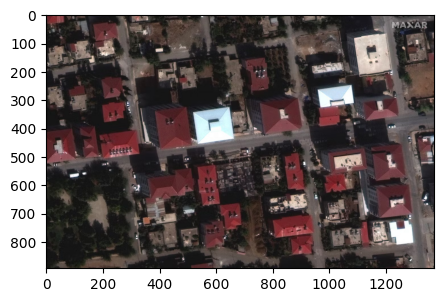

In [2]:
# define filepath
fpath = os.path.join('data', 'original', 'image_2.jpeg')

# load from file into numpy array
arr = quicklook.load(fpath)

# show numpy array
quicklook.show(arr)

#### 2. Image preprocessing

Quicklook comes with some preprocessing out of the box with quicklook, for details see the [source code](https://github.com/samsammurphy/quicklook/blob/main/quicklook/quicklook.py)


In [3]:
# replace array elements that are "not a number" with min valid number
arr = quicklook.replace_nan(arr)

# clip extreme pixel values
percentile = 2
arr = quicklook.percentile_clip(arr, percentile)

# scale pixels values to 0 - 255 and 8bit depth
arr = quicklook.bytescale(arr)

# (optionally) scale between 0 and 1 (common in computer vision)
arr = arr / 255

#### 3. Detect major types of objects

Detect buildings, cars, airplanes, etc. Here we are using [MMDetection](https://github.com/open-mmlab/mmdetection) and their pretrained pytorch model for general object detection from aerial images. Here are the [installation](https://mmdetection.readthedocs.io/en/latest/get_started.html) instructions.

In [4]:
input_filepath = 'data/original/image_6.jpeg'

# using their command line tool for quick demo
demo_cli = 'mmdetection/demo/image_demo.py'

# model config
config_file = '/Users/sam/code/footprints/models/rtmdet/large/rtmdet_x_8xb32-300e_coco.py'  

# model weights
checkpoint_file = '/Users/sam/code/footprints/models/rtmdet/large/rtmdet_x_8xb32-300e_coco_20220715_230555-cc79b9ae.pth' 

# bash command
command = f"python {demo_cli} {input_filepath} {config_file} --weights {checkpoint_file} --device cpu"

# Execute the command
get_ipython().system(command)


Loads checkpoint by local backend from path: /Users/sam/code/footprints/models/rtmdet/large/rtmdet_x_8xb32-300e_coco_20220715_230555-cc79b9ae.pth
11/17 15:57:33 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.
/Users/sam/.pyenv/versions/3.10.0/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '
/Users/sam/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/functional.━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   
py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be require

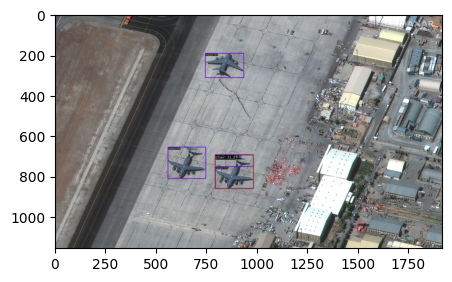

In [5]:
# visualize results
quicklook.show(quicklook.load('/Users/sam/code/footprints/outputs/vis/image_6.jpeg'))

This model ^ struggled with building footprints. Some options to handle this going forwards..

1. evaluate more models and compare performance 
2. apply transfer learning of existing models to specific use case (if labelled data is available)
3. use different models for different use cases

#### Building footprints

Here were are using a model that specializes in building footprint segmentation from this [github repo](https://github.com/fuzailpalnak/building-footprint-segmentation/blob/main/examples/Prediction.ipynb)

In [23]:
from building_detection import detect_buildings, plot_predictions

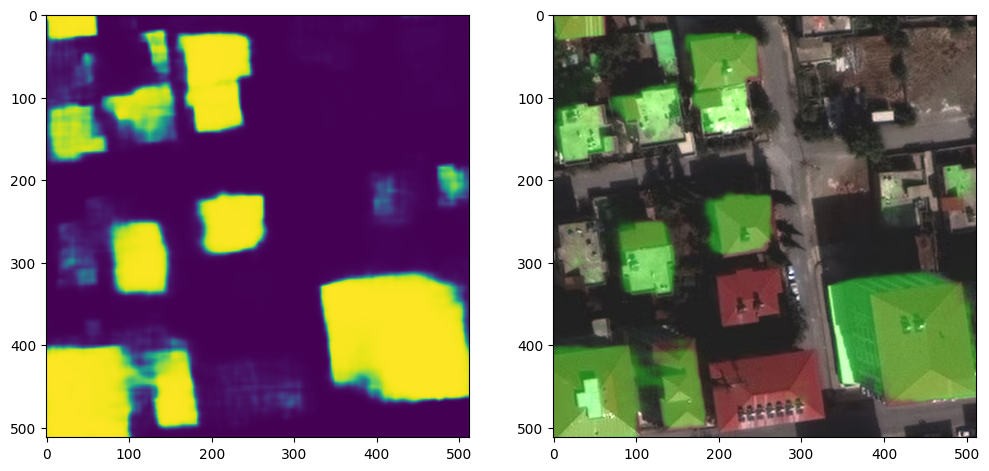

In [7]:
fpath = os.path.join('data', 'original' ,'image_2.jpeg')

predictions = detect_buildings(fpath)

plot_predictions(predictions)

#### GeoJson

In [8]:
import geopandas as gpd
import rasterio
from rasterio import features
import numpy as np

As JPEG files are not georefenced images (i.e. rasters) we cannot extract georeferenced shapes (i.e. vectors) from them. 

Given a georeferenced images (e.g. GeoTiff) we could extract vectors (e.g. polygons) and save them to a geojson file. 

Here is an example using a random GeoTiff I had on disk

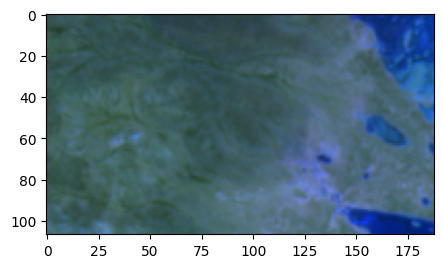

In [9]:
# a random geotiff I had on disk from the ASTER sensor (false colour composite with visible and infrared wavelengths)
arr = quicklook.load(os.path.join('data', 'aster', 'aster.tif'))
quicklook.show(arr)

In [10]:
# convert the co-ordinate reference system (CRS) to EPSG:4326 (i.e. the CRS used by GeoJson)
!rio warp --dst-crs 'EPSG:4326' {os.path.join('data', 'aster', 'aster.tif')} {os.path.join('data', 'aster', 'aster_epsg4326.tif')} --overwrite

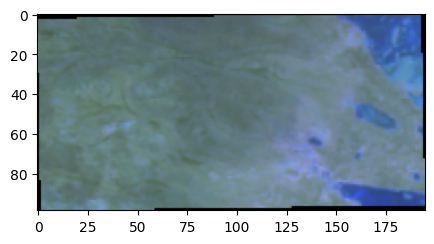

In [11]:
# take a look at the (warped) array
arr = quicklook.load(os.path.join('data', 'aster', 'aster_epsg4326.tif'))
quicklook.show(arr)

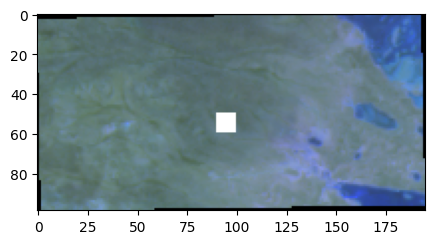

In [12]:
# make a writeable copy of the array
arr = np.copy(arr)

# let's put a square in there..
arr[50:60, 90:100, :] = 255
quicklook.show(arr)

In [13]:
# let's grab the georeferencing information we need
with rasterio.open(os.path.join('data', 'aster', 'aster_epsg4326.tif')) as src:
    transform=src.transform
    
# convert to a channels first array (as expected by rasterio)
channels_first = arr.transpose(2, 0, 1)

# define mask array 
mask = channels_first == 255

# find features in array (i.e. "polygonize")
shapes = features.shapes(channels_first, mask=mask, transform=src.transform)

# define a geojson-like feature collection
fc = ({"geometry": shape, "properties": {"value": value}} for shape, value in shapes)

# convert to geopandas dataframe
gdf = gpd.GeoDataFrame.from_features(fc)

# save to geojson file
gdf.to_file('example.geojson')

You can view this file at geojson.io

![geojson on map](images/geojson_on_map.png).

### Damaged buildings 

#### Dataset

[Xview2](https://xview2.org/) is an example dataset for damaged buildings.

#### Damage assessment

Generally speaking there are three types of information we can use to classify images: spatial, spectral and temporal. For a typical CNN approach (e.g. U-net based architectures) we are using spatial (i.e. where things are located) and spectral (e.g. red,green,blue) information. 

I would recommend including temporal information for damage assessment to improve performance (e.g. F1 score). Buildings are usually quite persistent through time. Where they are not persistent the chronological order matters (e.g. was it under construction or was it damaged?).

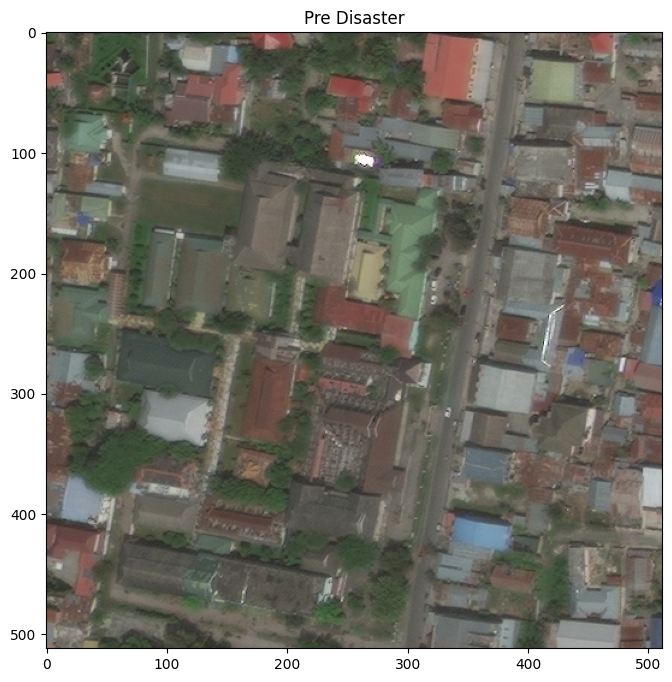

In [14]:
tsunami_dir = os.path.join('data', 'palu-tsunami', '143')

fpaths = {
    'pre':os.path.join(tsunami_dir, 'pre.png'),
    'post':os.path.join(tsunami_dir, 'post.png')
}

pre_disaster = quicklook.load(fpaths['pre'])
post_disaster = quicklook.load(fpaths['post'])

quicklook.show(pre_disaster, title='Pre Disaster', figsize=(8,8))

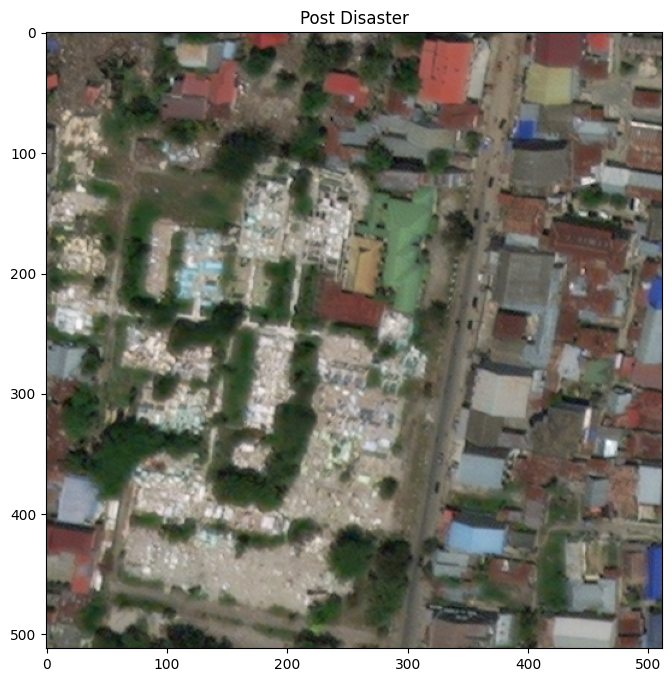

In [15]:
quicklook.show(post_disaster, title='Post Disaster', figsize=(8,8))

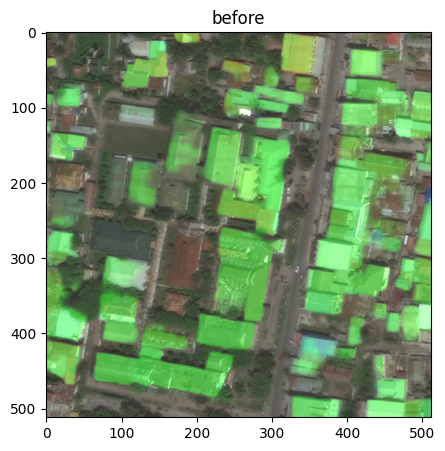

In [16]:
binary_prediction_before, colour_prediction_before = detect_buildings(fpaths['pre'])
quicklook.show(colour_prediction_before, title='before')

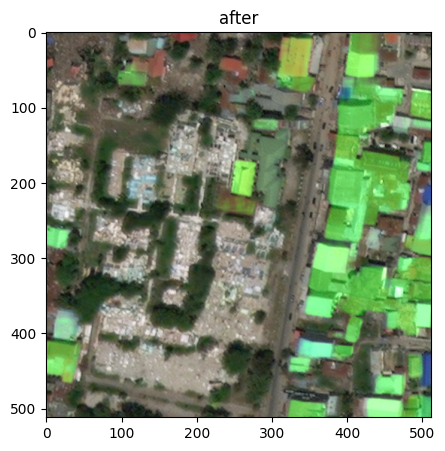

In [17]:
binary_prediction_after, colour_prediction_after = detect_buildings(fpaths['post'])
quicklook.show(colour_prediction_after, title='after')

In [18]:
import cv2

In [19]:
def detect_damage(before_binary, after_binary, threshold = 0.7):
    # measure damage by comparing before and after binary predictions of building footprints
    # uses dilation to mitigate edge effects of building detections

    kernel = np.ones((3,3))
    
    dilated_after = cv2.dilate(after_binary, kernel, iterations=4)
    
    delta = before_binary - dilated_after

    damage = (delta > threshold).astype(np.uint8)

    dilated_damage = cv2.dilate(damage, kernel, iterations=4)
    
    return dilated_damage

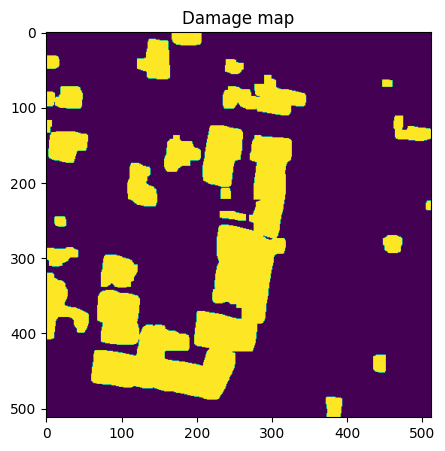

In [20]:
damage = detect_damage(binary_prediction_before, binary_prediction_after)
quicklook.show(damage, title='Damage map')

In [21]:
def plot_damage(post_disaster, damage):

    # create a new copy
    arr = post_disaster.copy()

    # ignore alpha band if there is one
    arr = arr[:,:,:3]

    # update colour channels to highlight damaged areas
    arr[:,:,0] = (arr[:,:,0] * damage) + (arr[:,:,0] * 0.8)
    arr[:,:,1] = (arr[:,:,1] * damage) + (arr[:,:,1] * 0.8)
    arr[:,:,2] = (arr[:,:,2] * damage) + (arr[:,:,2] * 0.8)

    # 
    quicklook.show(arr, cmap='grey', title='Damaged buildings', figsize=(8,8))

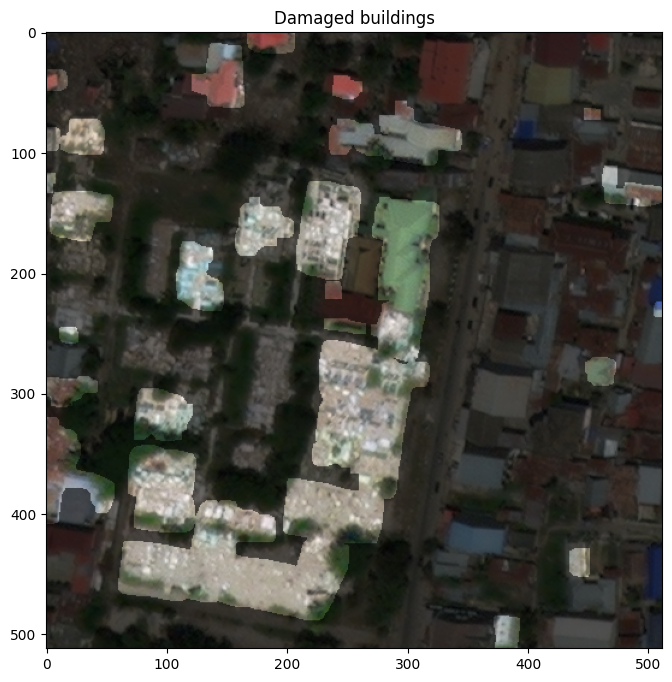

In [22]:
plot_damage(post_disaster, damage)